## 0 Imports and Constants

In [1]:
## 0 Imports and Constants
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import seaborn as sns
from torch.utils.data import DataLoader
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_clas, train_test_split, accuracy
from visual_evaluation import visualize
from predictive_evaluation import predictive_evaluation
from discriminative_model import LSTMClassification, CNNClassification
from baseline_model.LSTM import train_model
from baseline_model.TimeSeriesDataset import TimeSeriesDataset

DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"

In [2]:
MODEL = "cnn"

if MODEL == "lstm":
    hyperparameters = {
        "seq_len": 12,
        "lr": 0.0001,
        "batch_size": 32,
        "hidden_size": 4,
        "num_layers": 1,
        "bidirectional": True,
        "output_logits": True,
        "num_epochs": 1000,
        "device": 'cuda' if torch.cuda.is_available() else 'cpu'
    }

elif MODEL == "cnn":
    hyperparameters = {
        "lr": 0.0001,
        "batch_size": 32,
        "num_epochs": 1000,
        "device": 'cuda' if torch.cuda.is_available() else 'cpu'
    }

## 1 Loading Data

In [3]:
data = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_train' / 'discriminative_train_42000_13_5.csv', shape=(42000, 13, 5))

In [4]:
train, test = train_test_split(data, split_ratio=0.8)
test, val = train_test_split(test, split_ratio=0.5)

In [5]:
X_train, y_train, X_test, y_test, X_val, y_val = extract_features_and_targets_clas(train, test, val)

In [6]:
scaler = Scaler(X_train)

In [7]:
X_train = scaler.scale_data(X_train)
X_test = scaler.scale_data(X_test)
X_val = scaler.scale_data(X_val)

In [8]:
# put data on tensors (since they had to be numpy arrays for the scaler)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [9]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
val_dataset = TimeSeriesDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=hyperparameters["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters["batch_size"], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters["batch_size"], shuffle=False)

## 2 Training the model

In [10]:
criterion = nn.BCEWithLogitsLoss()

In [11]:
val_losses = []
val_accs = []
train_losses = []
train_accs = []

In [12]:
if MODEL == 'LSTM':

    model = LSTMClassification(
        device=hyperparameters["device"],
        batch_size=hyperparameters["batch_size"],
        input_size=X_train.shape[2],
        hidden_size=hyperparameters["hidden_size"],
        num_stacked_layers=hyperparameters["num_layers"],
        bidirectional=hyperparameters["bidirectional"],
        output_logits=hyperparameters["output_logits"]
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters["lr"])

    train_losses, train_accs, val_losses, val_accs, model = train_model(
                        model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        criterion=criterion,
                        optimizer=optimizer,
                        device=hyperparameters["device"],
                        num_epochs=hyperparameters["num_epochs"],
                        verbose=True)
    
elif MODEL == 'cnn':

    ### Model ### 
    model = CNNClassification(verbose=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['lr'])

    ### Training Loop
    patience = 10
    best_val_loss = np.inf
    num_epochs_no_improvement = 0

    for epoch in tqdm(range(hyperparameters['num_epochs'])):

        ### Training ###
        accumulated_train_loss = 0

        for _, (X_train, _) in enumerate(train_loader):

            model.train()
            X_train = X_train.float().to(hyperparameters['device'])

            X_train_hat = model(X_train)

            # weigh first 2 features higher
            X_train_hat_copy = X_train_hat.clone()
            X_train_copy = X_train.clone()

            X_train_hat_copy[:, :, 0] *= 2
            X_train_hat_copy[:, :, 1] *= 2
            X_train_copy[:, :, 0] *= 2
            X_train_copy[:, :, 1] *= 2

            train_loss = criterion(X_train_hat, X_train)
            accumulated_train_loss += train_loss.item()

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()


        ### Validation ###
        accumulated_val_loss = 0
        model.eval()
        with torch.inference_mode():

            for _, (X_val, _) in enumerate(val_loader):
                X_val = X_val.float().to(hyperparameters['device'])

                X_val_hat = model(X_val)

                # weigh first 2 features higher
                X_val_hat_copy = X_val_hat.clone()
                X_val_copy = X_val.clone()

                X_val_hat_copy[:, :, 0] *= 2
                X_val_hat_copy[:, :, 1] *= 2
                X_val_copy[:, :, 0] *= 2
                X_val_copy[:, :, 1] *= 2

                val_loss = criterion(X_val_hat, X_val)
                accumulated_val_loss += val_loss.item()


            # Check for early stopping
            if accumulated_val_loss < best_val_loss:
                best_val_loss = accumulated_val_loss
                num_epochs_no_improvement = 0

            else:
                print(f'INFO: Validation loss did not improve in epoch {epoch + 1}')
                num_epochs_no_improvement += 1


        ### Logging and Plotting ###

        print(f'Epoch: {epoch} \n\b Train Loss: {accumulated_train_loss / len(train_loader)} \n\b Val Loss: {accumulated_val_loss / len(val_loader)}')
        print('*' * 50)

        if epoch % 10 == 0:
            plot_train = dc(X_train.detach().numpy())
            plot_hat = dc(X_train_hat.detach().numpy())

            plt.figure(figsize=(10, 5))
            plt.title(f'Epoch {epoch} | Original vs Synthetic')
            plt.plot(plot_train[0, :, 0], label='Original')
            plt.plot(plot_hat[0, :, 0], label='Synthetic')
            plt.legend()

        if num_epochs_no_improvement >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

        


  0%|          | 0/1000 [00:00<?, ?it/s]


Input after unsqueeze and permute: torch.Size([32, 5, 12])
After conv1: torch.Size([32, 5, 6])
After conv2: torch.Size([32, 5, 4])
After conv3: torch.Size([32, 5, 1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (160x1 and 5x1)

## 3 Evaluate Training

Text(0.5, 1.0, 'Validation Accuracy')

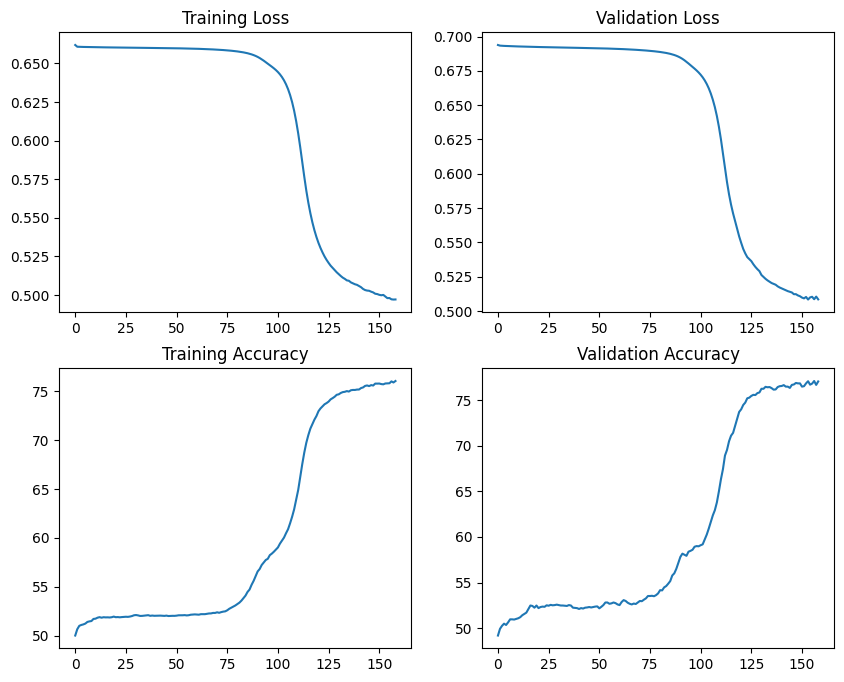

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Diagramm 1 (oben links)
axs[0, 0].plot(train_losses, label="BCELoss")
axs[0, 0].set_title('Training Loss')

axs[0, 1].plot(val_losses, label="BCELoss")
axs[0, 1].set_title('Validation Loss')

axs[1, 0].plot(train_accs, label="Accuracy")
axs[1, 0].set_title('Training Accuracy')

axs[1, 1].plot(val_accs, label="Accuracy")
axs[1, 1].set_title('Validation Accuracy')

In [ ]:
def get_test_performance(model, X_test, y_test):

    with torch.inference_mode(): 
        test_logits = model(X_test.to(hyperparameters["device"])) # get plain model output (logits)
        test_probs = torch.sigmoid(test_logits) # get probabilities
        test_preds = torch.round(test_probs) # get classes

        test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
        test_loss = criterion(test_logits, y_test).item()

    return test_acc, test_loss

In [ ]:
acc, loss = get_test_performance(model, X_test, y_test)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {acc}')

Test Loss: 0.4961903691291809
Test Accuracy: 78.33333333333333


/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_72007/82100743.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
